In [1]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import norm, sem, t
import matplotlib.mlab as mlab
import re
%matplotlib inline
plt.style.use('seaborn')

In [7]:
def RunRandomForest(df, question, features, featureSubset):
    
    df['is_train'] = np.random.uniform(0, 1, len(df)) <= .5
    
    for ID in featureSubset.id:
    
        newHeader = ID + 'feature'
        df[newHeader] = pd.factorize(df[ID])[0]

    # Create two new dataframes, one with the training rows, one with the test rows
    train, test = df[df['is_train']==True], df[df['is_train']==False]

    # train[Question] contains the actual species names. Before we can use it,
    # we need to convert each species name into a digit. So, in this case there
    # are three species, which have been coded as 0, 1, or 2.
    y = pd.factorize(train[question])[0]

    # Create a random forest classifier. By convention, clf means 'classifier'
    clf = RandomForestClassifier(n_jobs=4,n_estimators=128);

    # Train the classifier to take the training features and learn how they relate
    # to the training y (the species)
    clf.fit(train[features], y);

    # Apply the classifier we trained to the test data (which, remember, it has never seen before)
    clf.predict(test[features]);

    # View a list of the features and their importance scores
    return train[features], clf.feature_importances_

def RepeatedRandomForests(df, question, filename, featureSubset, iterations=100):
    
    locs = ((df[question] != 'Valid Skip') | (df[question] != 'NA')) 
    
    # Create a list of the feature column's names
    features = df[locs].columns[190:]

    importanceMeasures = np.zeros(len(features))

    start = time.clock();

    for i in np.arange(0,iterations):
        
        trained, importance = RunRandomForest(df, question, features, featureSubset);
    
        importanceMeasures = np.vstack((importanceMeasures, importance))

    time_elapsed = time.clock() - start;

    print(time_elapsed, 's')

    fd = open(filename,'ab')
    np.savetxt(fd, importanceMeasures, delimiter=',')
    fd.close()

    return trained, importanceMeasures, features

def mean_confidence_interval(data, confidence=0.95):
    
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), sem(a)
    h = se * t._ppf((1+confidence)/2., n-1)
    return m, h

def checkFeature(factor):
    
    feature = relImportance[factor]
    weights = np.ones_like(feature)/float(len(feature))

    plt.figure(num=None, figsize=(4, 3), dpi=120, 
               facecolor='w', edgecolor='k')
    
    n, bins, patches = plt.hist(feature, 20, weights=weights,
                                facecolor='green', alpha=0.75)
    
    plt.title("Distribution for " + factor)
    plt.xlabel("Relative Importance")
    plt.ylabel("Frequency")

    
#     (mu, sigma) = norm.fit(feature)
# #     # add a 'best fit' line
#     y = mlab.normpdf( bins, mu, sigma)
#     l = plt.plot(bins, y, 'r--', linewidth=2)

#     plt.legend(["Fit","Distribution"])
    
def plotImportance(relImportance,features,questions,question,iterations=100):
    
    fig = plt.figure(num=None, 
               figsize=(18, 36), 
               dpi=150, 
               facecolor='w', 
               edgecolor='k')
    
    ax = fig.add_subplot(111)

    importances = relImportance.mean();
    mean, ci = mean_confidence_interval(relImportance);
    indices = np.argsort(importances);

    #questionStatement = str(list(questions[questions['id'] == question]['statement']));
    
    plt.barh(range(len(indices)), importances[indices], 
             color='g', align='center',
             xerr = ci[indices])
    
    tags = []
    
    for i in range(len(features)):
        tags.append(questions[questions['feature'] == features[indices][i]]['shortname'].values)
    
    plt.yticks(range(len(indices)), tags)
    #plt.yticks(range(len(indices)), questions['shortname'][indices])
    plt.xlabel('Relative Importance')
    plt.title('Important Features for ' + question)# + "\n" + questionStatement)
    
    label = 'Iterations: ' + str(iterations)
    
    bbox_props = dict(boxstyle="round4,pad=0.3", fc="white", lw=1)
    t = ax.text(0.18, 0.12, label, ha="center", va="center", rotation=0, size=12, bbox=bbox_props)
        
def plotCumuluativeImportance(relImportance,features,questions,iterations=100):
    
    importances = relImportance.mean()
    mean, ci = mean_confidence_interval(relImportance)
    indices = np.argsort(importances)[::-1]

    fig = plt.figure(num=None, 
                   figsize=(10, 3), 
                   dpi=120, 
                   facecolor='w', 
                   edgecolor='k')

    ax = fig.add_subplot(111)


    cumulative = np.cumsum(importances[indices])
    plt.errorbar(np.arange(0,len(cumulative)),cumulative,yerr=ci[indices])
    plt.title('Cumulative Importance')
    plt.ylabel('Importance (arb. units)')
    plt.xlabel('Feature')
    
    tags = []
    
    for i in range(len(features)):
        tags.append(questions[questions['feature'] == features[indices][i]]['shortname'].values[0])
    
    plt.xticks(range(len(cumulative)), tags, rotation=90);
    
    label = 'Iterations: ' + str(iterations)
    
    bbox_props = dict(boxstyle="round4,pad=0.3", fc="white", lw=1)
    t = ax.text(2, 0.9, label, ha="center", va="center", rotation=0, size=12, bbox=bbox_props)

In [3]:
folder='survey_data/';
XLS = pd.ExcelFile(folder + 'LabeledComputationData.xlsx')
XLS2 = pd.ExcelFile(folder + 'CategorizedQuestions.xlsx')
df = XLS.parse('LabeledComputationData')
questions = XLS2.parse('Sheet1')

In [9]:
question = 'Q1';
filename = 'analyzed_data/TeachCompAll10.csv';
iterations = 10;

featureSubset = questions[((questions['scale'] == 'personal') | (questions['scale'] == 'department')) & 
          (questions['qtype'] !='open')];

trained, featureImportances, features = RepeatedRandomForests(df, question, filename, featureSubset, iterations);
list(featureImportances)
relImportance = pd.read_csv(filename, names=trained);

4.128997999999999 s


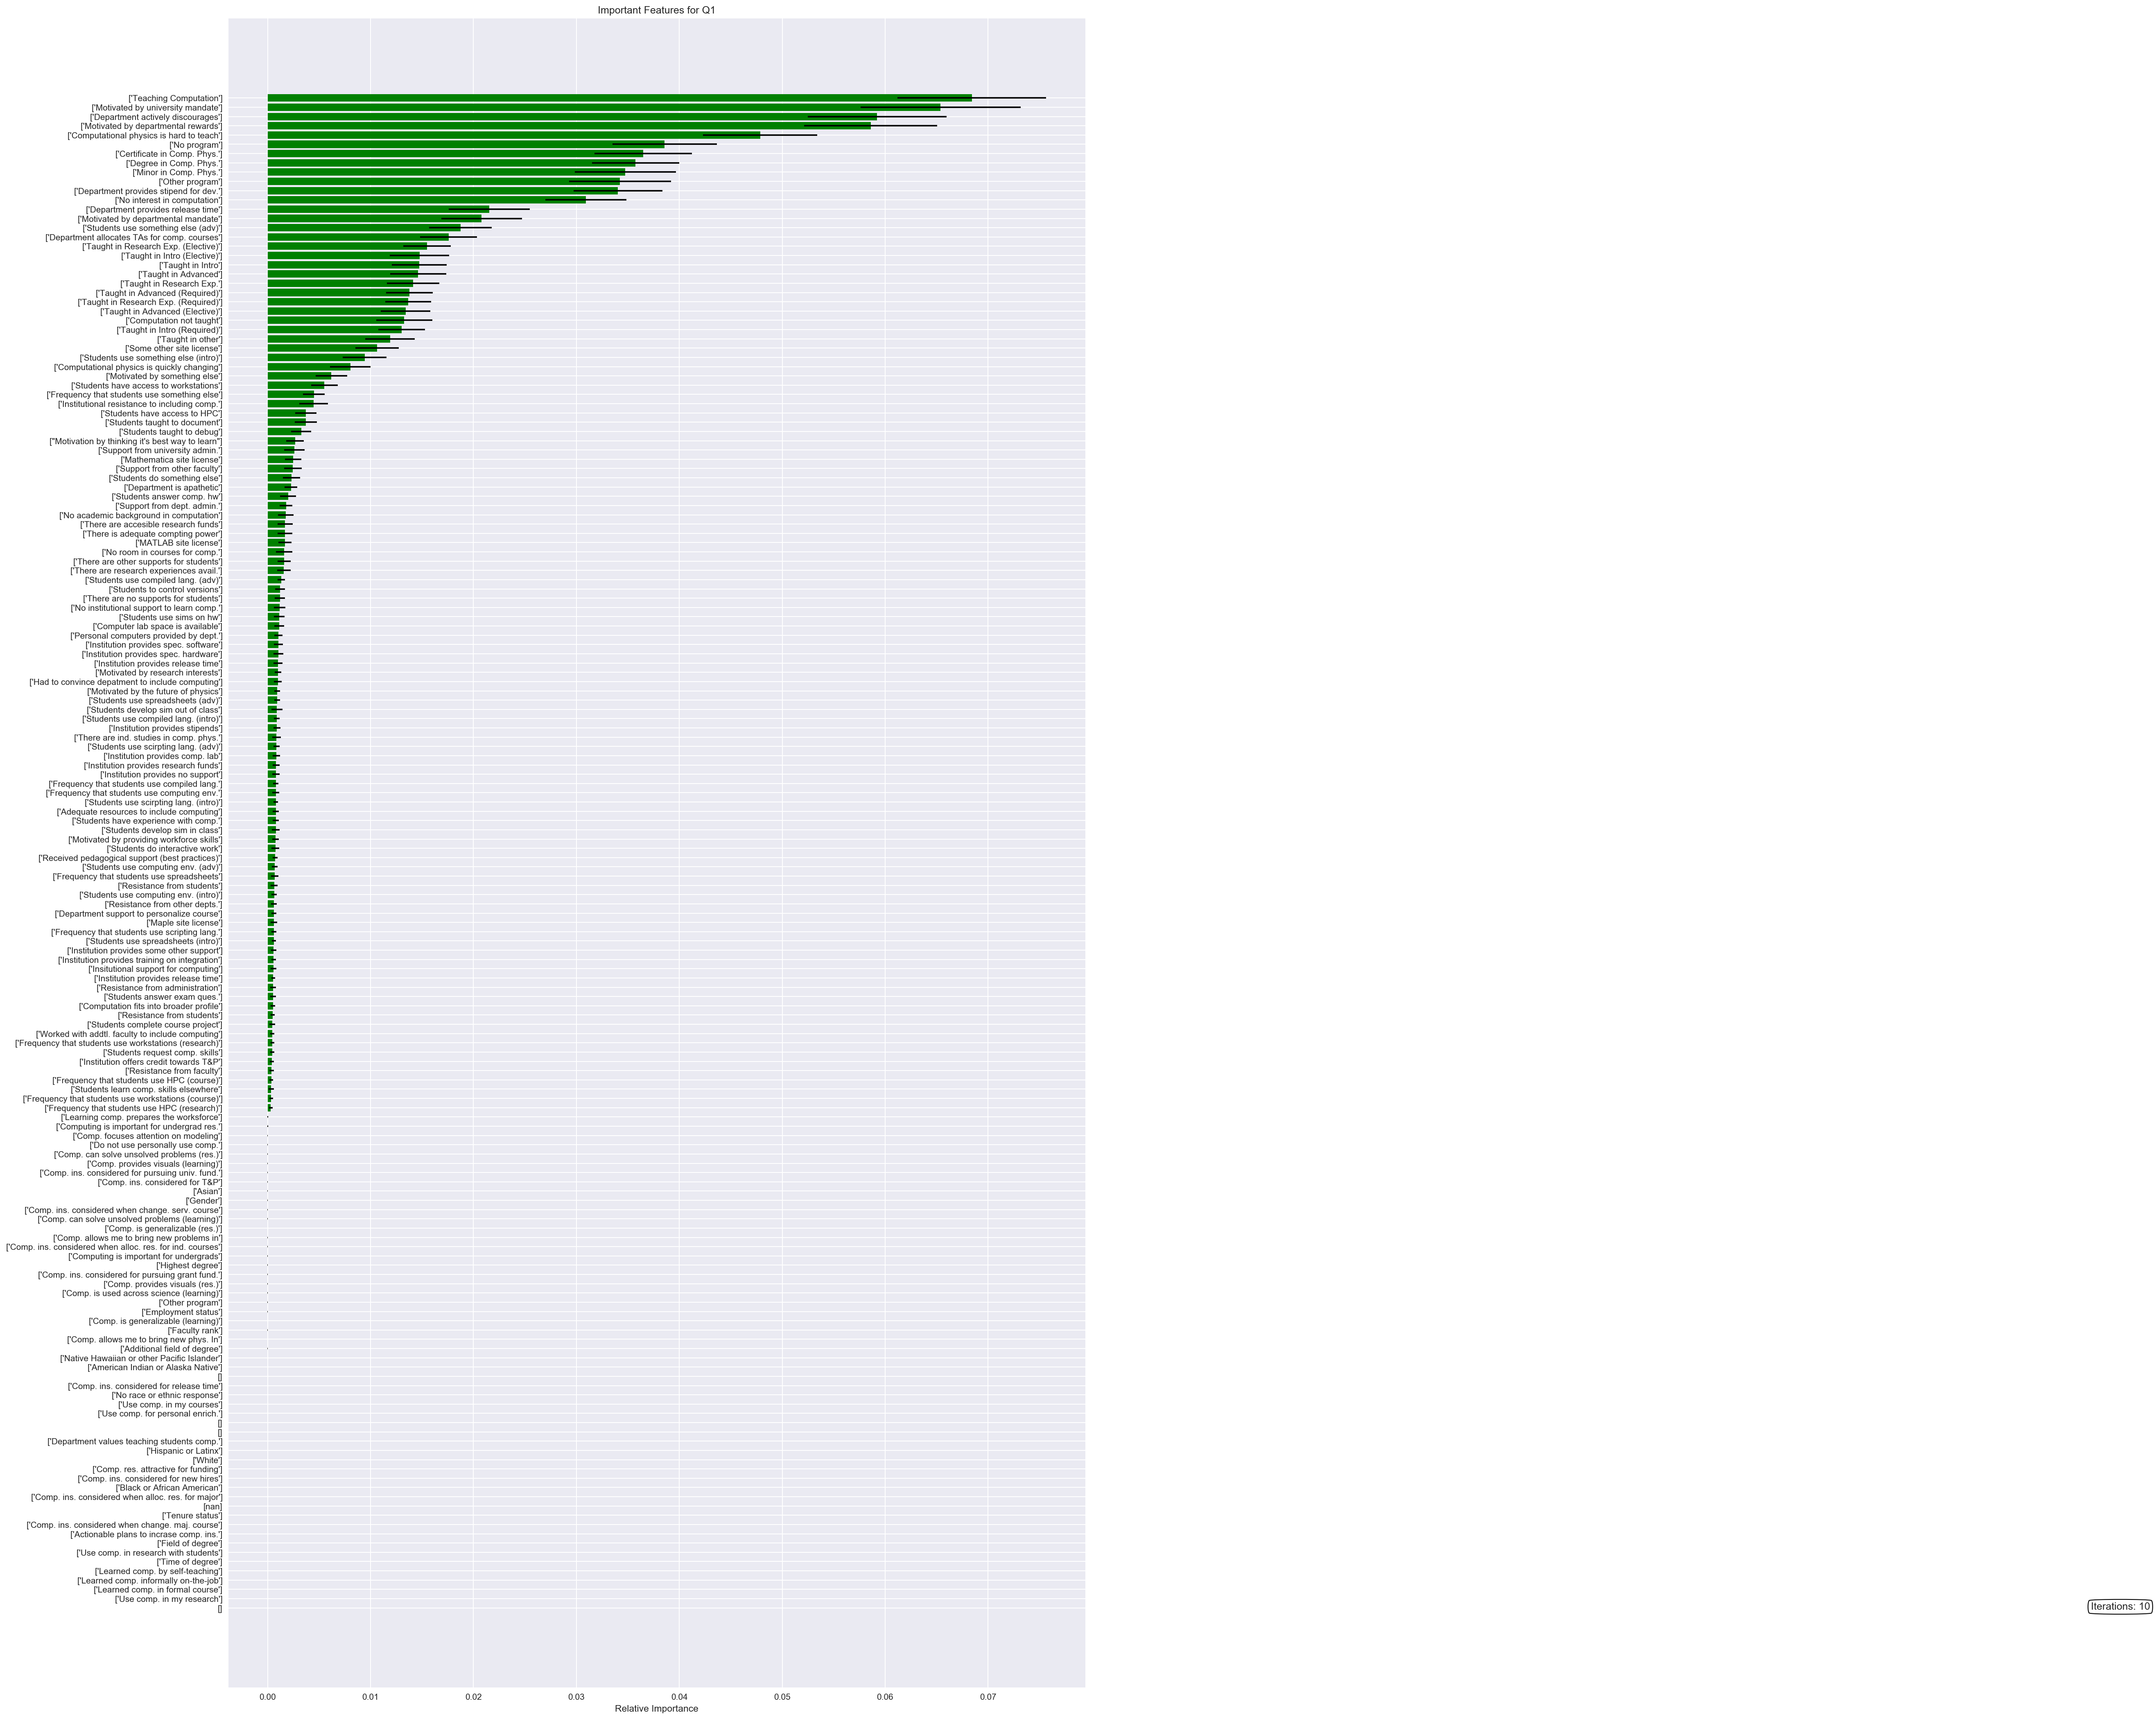

In [10]:
plotImportance(relImportance,features,questions,question,iterations)